In [1]:
import os
import gc
import time
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as m
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

# Datasets

In [2]:
# получение путей к файлам
tiff_files = []
csv_files = []
directory = 'data/train'
for root, dirs, files in os.walk(directory, topdown = False):
   for file in files:
        if os.path.splitext(file)[1] == '.tiff':
            tiff_files.append(os.path.join(root, file))
        if os.path.splitext(file)[1] == '.csv':
            csv_files.append(os.path.join(root, file))    

In [3]:
%%time
# формирование тренировочного датасета
list_of_df = []
for file_tiff in tiff_files:
    with rasterio.open(file_tiff) as src:
        df = pd.DataFrame(src.read(5).reshape(-1, 1))
        df.columns = ['target']
        for i in range(1, 5):
            df[f'band{i}'] = src.read(i).reshape(-1, 1)
        list_of_df.append(df)

CPU times: user 155 ms, sys: 83.8 ms, total: 239 ms
Wall time: 262 ms


In [4]:
for df, file_csv in zip(list_of_df, csv_files):
    df_csv = pd.read_csv(file_csv)
    df_csv.columns = ['date', 't_min', 't_avg', 't_max', 'rains', 'wind_way', 'wind_speed', 'wind_s', 'pressure']       
    for i, j in enumerate(df_csv['t_max'].tolist()):
        df[f't_max_day{-62 + i}'] = j

In [5]:
for df, file_csv in zip(list_of_df, csv_files):
    df_csv = pd.read_csv(file_csv)
    df_csv.columns = ['date', 't_min', 't_avg', 't_max', 'rains', 'wind_way', 'wind_speed', 'wind_s', 'pressure']   
    for i, j in enumerate(df_csv['wind_way'].tolist()):
        df[f't_wind_way_day{-62 + i}'] = j

In [6]:
for df, file_csv in zip(list_of_df, csv_files):
    df_csv = pd.read_csv(file_csv)
    df_csv.columns = ['date', 't_min', 't_avg', 't_max', 'rains', 'wind_way', 'wind_speed', 'wind_s', 'pressure']   
    for i, j in enumerate(df_csv['wind_speed'].tolist()):
        df[f't_win_speed_day{-62 + i}'] = j 

In [7]:
for df, file_csv in zip(list_of_df, csv_files):
    df_csv = pd.read_csv(file_csv)
    df_csv.columns = ['date', 't_min', 't_avg', 't_max', 'rains', 'wind_way', 'wind_speed', 'wind_s', 'pressure']
    for i, j in enumerate(df_csv['pressure'].tolist()):
        df[f't_pressure_day{-62 + i}'] = j

In [8]:
for df, file_csv in zip(list_of_df, csv_files):
    df_csv = pd.read_csv(file_csv)
    df_csv.columns = ['date', 't_min', 't_avg', 't_max', 'rains', 'wind_way', 'wind_speed', 'wind_s', 'pressure']   
    for i, j in enumerate(df_csv['rains'].tolist()):
        df[f't_rains_day{-62 + i}'] = j            

In [9]:
df_train = list_of_df[1]
for df in list_of_df[2:-1]:
    df_train = pd.concat([df_train, df])
df_train.reset_index(drop=True, inplace=True)   

df_valid = list_of_df[0]
df_valid.reset_index(drop=True, inplace=True)  

df_test = list_of_df[-1]
df_test.reset_index(drop=True, inplace=True)   

In [10]:
df_test

,target,band1,band2,band3,band4,t_max_day-62,t_max_day-61,t_max_day-60,t_max_day-59,t_max_day-58,...,t_rains_day-10,t_rains_day-9,t_rains_day-8,t_rains_day-7,t_rains_day-6,t_rains_day-5,t_rains_day-4,t_rains_day-3,t_rains_day-2,t_rains_day-1
0,0.0,16.0,19.0,21.0,32.0,2.5,-0.5,-5.8,-11.5,-15.4,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0
1,0.0,9.0,11.0,17.0,26.0,2.5,-0.5,-5.8,-11.5,-15.4,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0
2,0.0,8.0,10.0,15.0,23.0,2.5,-0.5,-5.8,-11.5,-15.4,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0
3,0.0,7.0,9.0,13.0,20.0,2.5,-0.5,-5.8,-11.5,-15.4,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0
4,0.0,6.0,8.0,11.0,18.0,2.5,-0.5,-5.8,-11.5,-15.4,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637787,0.0,33.0,38.0,48.0,67.0,2.5,-0.5,-5.8,-11.5,-15.4,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0
1637788,0.0,29.0,34.0,42.0,62.0,2.5,-0.5,-5.8,-11.5,-15.4,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0
1637789,0.0,21.0,26.0,36.0,57.0,2.5,-0.5,-5.8,-11.5,-15.4,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0
1637790,0.0,18.0,23.0,31.0,52.0,2.5,-0.5,-5.8,-11.5,-15.4,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0


In [11]:
df_train.shape  

(2844540, 315)

In [12]:
df_valid.shape

(44376, 315)

In [13]:
df_test.shape

(1637792, 315)

In [14]:
X_train = df_train.drop(['target'], axis=1)
y_train = df_train['target']

X_valid = df_valid.drop(['target'], axis=1)
y_valid = df_valid['target']

X_test = df_test.drop(['target'], axis=1)
y_test = df_test['target']

# Model

In [16]:
train_pool = Pool(
        X_train, 
        y_train, 
    )
valid_pool = Pool(
        X_valid, 
        y_valid, 
    )

In [17]:
%%time
clf = CatBoostClassifier(random_state=42,
                         task_type='GPU',
                         learning_rate=0.005,
                         iterations=1400,
                         eval_metric='AUC'
                        )
clf.fit(train_pool, eval_set=valid_pool, verbose=300, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7003617	best: 0.7003617 (0)	total: 77.9ms	remaining: 1m 48s
300:	test: 0.7136925	best: 0.7237613 (100)	total: 8.36s	remaining: 30.5s
600:	test: 0.7340900	best: 0.7340900 (600)	total: 16.7s	remaining: 22.2s
900:	test: 0.7615753	best: 0.7620981 (765)	total: 25s	remaining: 13.8s
1200:	test: 0.7668276	best: 0.7668276 (1200)	total: 33.1s	remaining: 5.48s
1399:	test: 0.7704752	best: 0.7704752 (1399)	total: 38.4s	remaining: 0us
bestTest = 0.7704752088
bestIteration = 1399
CPU times: user 1min 19s, sys: 12.6 s, total: 1min 32s
Wall time: 40.5 s


In [18]:
print(f'ROC_AUC {m.roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1]):2.5f}')

ROC_AUC 0.77048


In [19]:
print(f'ROC_AUC {m.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]):2.5f}')

ROC_AUC 0.81675


# Predict

In [20]:
# указать пути к тестовым файлам 
with rasterio.open(tiff_files[-1]) as src:
        test_shape = (src.read(1).shape)
        df = pd.DataFrame(src.read(1).reshape(-1, 1))
        df.columns = ['band1']
        for i in range(2, 5):
            df[f'band{i}'] = src.read(i).reshape(-1, 1)
        df_csv = pd.read_csv(csv_files[-1])
        df_csv.columns = ['date', 't_min', 't_avg', 't_max', 'rains', 'wind_way', 'wind_speed', 'wind_s', 'pressure']
        for i, j in enumerate(df_csv['t_max'].tolist()):
            df[f't_max_day{-62 + i}'] = j 
        for i, j in enumerate(df_csv['wind_way'].tolist()):
            df[f't_wind_way_day{-62 + i}'] = j
        for i, j in enumerate(df_csv['wind_speed'].tolist()):
            df[f't_win_speed_day{-62 + i}'] = j  
        for i, j in enumerate(df_csv['pressure'].tolist()):
            df[f't_pressure_day{-62 + i}'] = j   
        for i, j in enumerate(df_csv['rains'].tolist()):
            df[f't_rains_day{-62 + i}'] = j         
        
df

,band1,band2,band3,band4,t_max_day-62,t_max_day-61,t_max_day-60,t_max_day-59,t_max_day-58,t_max_day-57,...,t_rains_day-10,t_rains_day-9,t_rains_day-8,t_rains_day-7,t_rains_day-6,t_rains_day-5,t_rains_day-4,t_rains_day-3,t_rains_day-2,t_rains_day-1
0,16.0,19.0,21.0,32.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0
1,9.0,11.0,17.0,26.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0
2,8.0,10.0,15.0,23.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0
3,7.0,9.0,13.0,20.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0
4,6.0,8.0,11.0,18.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637787,33.0,38.0,48.0,67.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0
1637788,29.0,34.0,42.0,62.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0
1637789,21.0,26.0,36.0,57.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0
1637790,18.0,23.0,31.0,52.0,2.5,-0.5,-5.8,-11.5,-15.4,-17.2,...,0.1,1.1,1.5,0.2,0.0,0.6,0.0,0.0,0.0,0.0


In [21]:
res = clf.predict_proba(df)[:,1]
res

array([0.13247768, 0.19205767, 0.18569602, ..., 0.07503794, 0.0786711 ,
       0.07978437])

## Кривая Precision-Recall

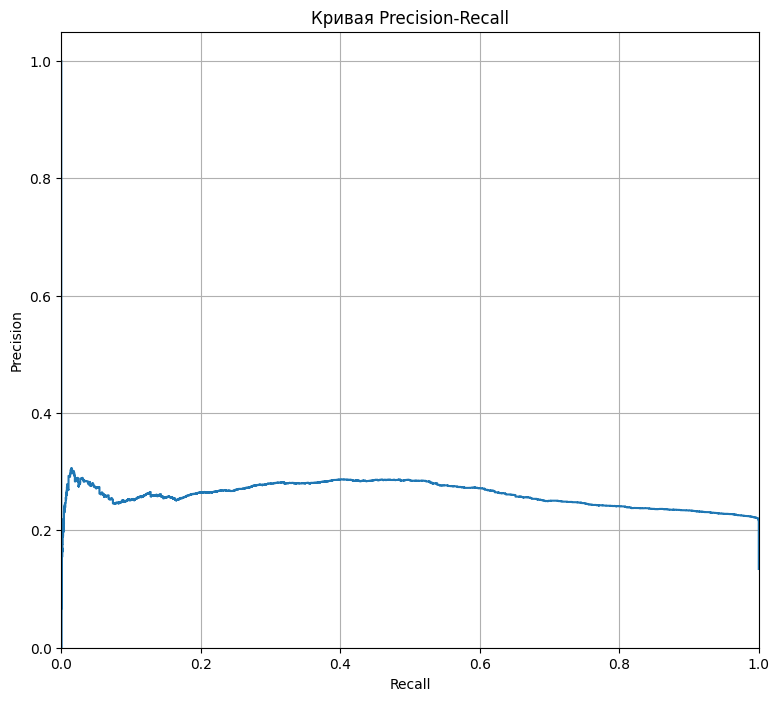

In [22]:
probabilities_valid = clf.predict_proba(X_valid)
precision, recall, thresholds = m.precision_recall_curve(y_valid, probabilities_valid[:, 1])

plt.figure(figsize=(9, 8))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

## ROC-кривая

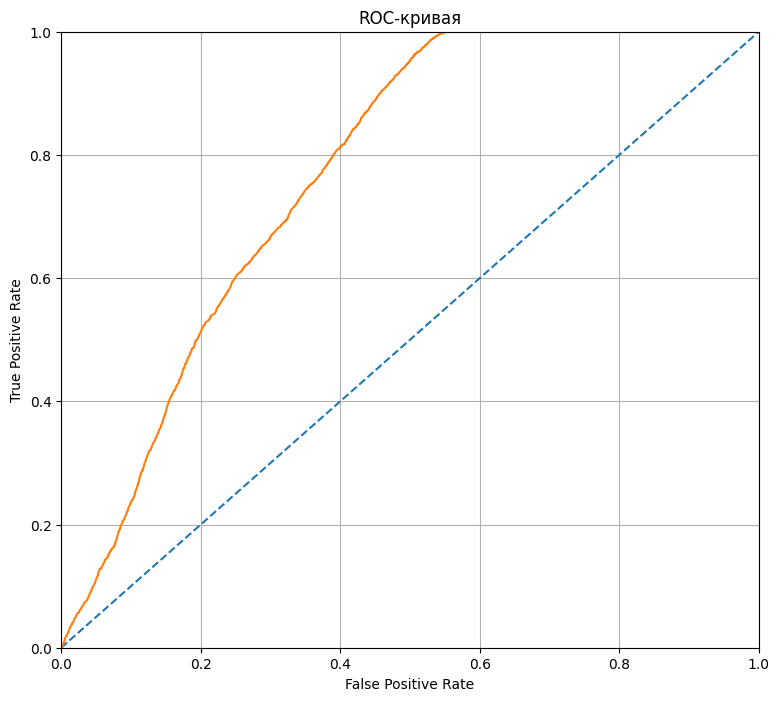

In [23]:
fpr, tpr, thresholds = m.roc_curve(y_valid, probabilities_valid[:, 1])

plt.figure(figsize=(9, 8))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

In [24]:
res = clf.predict_proba(df)[:,1]
res = np.array([1 if i > 0.12 else 0 for i in res ]).reshape(test_shape) # порог сам придумал, с 0.5 только 6 точек показал :)

In [25]:
res.shape

(992, 1651)

In [26]:
# визуализация изображения
def visualize_rgb_geotiff(file_path, r_band, g_band, b_band, ik_band, mask_band, photo_laer: str):
    try:
        with rasterio.open(file_path) as src:
            num_bands = src.count
            print(f"Number of bands: {num_bands}")
            red = src.read(r_band)  # B02 - Blue
            green = src.read(g_band)  # B03 - Green
            blue = src.read(b_band)  # B04 - Red
            ik = src.read(ik_band)
            mask = src.read(mask_band)

            if photo_laer == "full":
                photo = np.stack([red, green, blue], axis=-1)  # Отрисовка всего изображения
            elif photo_laer == "ik_laer":
                photo = np.stack([ik], axis=-1) # Отрисовка ИК-слоя изображения
            elif photo_laer == "mask_laer":
                photo = np.stack([mask], axis=-1)  # Отрисовка маски изображения
            photo = photo.astype(np.uint8)
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.imshow(photo)
            ax.axis('off')
            plt.show()
    except Exception as e:
        print(f'Ошибка: {e}')

## Оригинальная маска из 20 изображения

Number of bands: 5


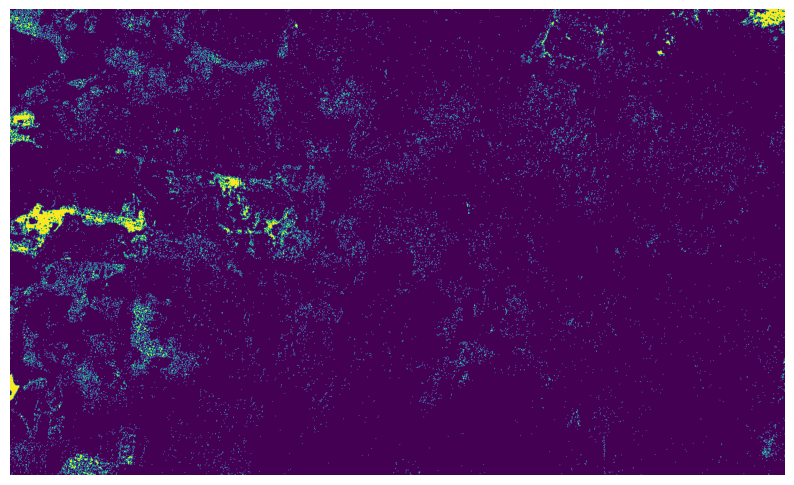

In [27]:
visualize_rgb_geotiff(tiff_files[-1], 1, 2, 3, 4, 5, "mask_laer")

## Предсказанная маска

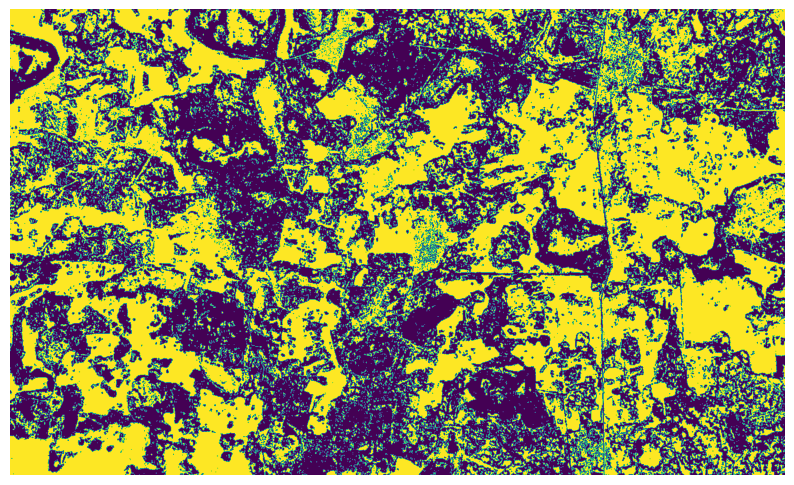

In [28]:
photo = np.stack([res], axis=-1)
photo = photo.astype(np.uint8)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(photo)
ax.axis('off')
plt.show()

# Обучение модели на всех данных для деплоя 

In [29]:
df_train = list_of_df[0]
for df in list_of_df[1:]:
    df_train = pd.concat([df_train, df])
df_train.reset_index(drop=True, inplace=True)

In [30]:
X = df_train.drop(['target'], axis=1)
y = df_train['target']

In [31]:
train_pool = Pool(X, y)

In [32]:
%%time
clf = CatBoostClassifier(random_state=42,
                         task_type='GPU',
                         learning_rate=0.005,
                         iterations=1400,
                        )
clf.fit(train_pool, verbose=200, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6847801	total: 47.7ms	remaining: 1m 6s
200:	learn: 0.1933290	total: 9.05s	remaining: 54s
400:	learn: 0.1589842	total: 18.2s	remaining: 45.4s
600:	learn: 0.1520563	total: 27.6s	remaining: 36.7s
800:	learn: 0.1490900	total: 36.7s	remaining: 27.4s
1000:	learn: 0.1470246	total: 45.7s	remaining: 18.2s
1200:	learn: 0.1454234	total: 54.8s	remaining: 9.07s
1399:	learn: 0.1441736	total: 1m 3s	remaining: 0us
CPU times: user 2min 4s, sys: 19.4 s, total: 2min 23s
Wall time: 1min 6s
